# Demonstrating the applications of sequence alignment
A SP2273 Project by Team Bed 🛏️



![](https://bioinformaticsreview.com/wp-content/uploads/2015/10/header-image-copy18-e1445709332524.jpg)

Source: https://bioinformaticsreview.com/20151024/muscle-tool-for-multiple-sequence-alignment/

## Introduction
### Sequence alignment and why it's important

Sequence alignments are useful in bioinformatics for identifying sequence similarity, producing phylogenetic trees, and developing homology models of protein structures. Alignments can reflect a degree of evolutionary change between sequences descended from a common ancestor.

Specific sequence motifs can function as regulatory sequences controlling biosynthesis, or as signal sequences that direct a molecule to a specific site within the cell or regulate its maturation. Since the regulatory function of these sequences is important, they are thought to be conserved across long periods of evolution. In some cases, evolutionary relatedness can be estimated by the amount of conservation of these sites.

A highly conserved sequence is one that has remained relatively unchanged far back up the phylogenetic tree, and hence far back in evolutionary time. Examples of highly conserved sequences include the RNA components of ribosomes present in all domains of life, the homeobox sequences widespread amongst Eukaryotes, and the tmRNA in Bacteria. The study of sequence conservation overlaps with the fields of genomics, proteomics, evolutionary biology, phylogenetics, bioinformatics and mathematics.

### Why can't we just Ctrl+F

DNA sequences of the same gene can vary significantly between species and even between individuals of the same species. It is statistically improbable that a query sequence will have a 100% match with the target genomic sequence or in other words, are identical sequences. Hence, Ctrl+F application in sequence alignment is severely limited.

Whole genome alignments (WGA) can be used to identify highly conserved regions across species. Even then, the accuracy and scalability of WGA tools remains limited due to the computational complexity of dealing with rearrangements, repeat regions and the large size of many eukaryotic genomes.

### Global alignment vs. Local alignment

 - Global Alignment
 
 Global alignment refers to the end-to-end alignment of two strings. In other words, we are attempting to directly align the query sequence to the genomic sequence. This is usually used in cases where the two sequences are already quite similar to each other. An example of such a tool is the [EMBOSS Needle](https://www.ebi.ac.uk/Tools/psa/emboss_needle/) [1], that directly compares two sequences and obtains their optimal alignment. 

 - Local Alignment
 
 Local alignment refers to the alignment of multiple substrings for two strings. In general they are used to find regions of high local similarity. It is useful when we do not know the boundaries of genes and where only a small domain of the gene may be conserved. Local alignment is also useful when searching for a small gene in a large chromosome. Examples of local alignment tools include the frequently used BLAST, and its variant BLAT. 


> In this project we write a sequence algorithm that takes inspiration from BLAST and BLAT. We then plan to analyze aspects of the algorithm, and finally apply our algorithm to real-world data. 


## Our implementation

### Rationale

Our algorithm is a simplified and modified version of two similar local alignment tools, [BLAST](https://blast.ncbi.nlm.nih.gov/Blast.cgi) [2] and [BLAT](https://doi.org/10.1101/gr.229202) [3]. A brief desciption of the framework of such an algorithm can be found in W J Kent's research paper on BLAT, the BLAST-like Alignment Tool. First, the matching stage of the algorithm will match subsequences of the query to the genomic sequence, and determines which sections seem to be homologous. After which, the sequences that then aligned to each other, which results in homology regions on the genomic sequence that satisfy certain conditions set by the algorithm. 

### Our take on local alignment vs BLAT/BLAST
Our algorithm differs from local alignment tools like BLAT and BLAST in two key areas. Firstly, while BLAT and BLAST make indexes of the query sequence and genomic sequence respetively, our code does not create indexes and simply runs through the genomic sequence once. Another difference is that our algorithm attempts to align the entire query sequence to the genome, whereas BLAT and BLAST algorithms allow for the query sequence to be split up into multiple homologous subsequences along the genomic sequence. This means that our algorithm is more like a global alignment algorithm rather than a local alignment algorithm. Nevertheless, we keep important features of BLAT and BLAST, such as the k-value used in the algorithm. This ensures that the analysis of our own algorithm can have applications to BLAT and BLAST. 

### Libraries

For this project, we decided to make use of an existing library in Python called Biopython. This library includes simple tools for biological computation, such as having in-built datatypes for DNA and amino acid sequences, as well as having useful functions such as Seq.translate(), which can translate a DNA sequence into its amino acid form. Other libraries used are common ones, such as numpy, matplotlib and random, as well as an extra library called Time which will come into use later. 

### Assumptions

For simplicity's sake, we will assume that we are in the correct reading frame at all times throughout the algorithm. In other words, the genomic sequence that we are analyzing is in the correct reading frame.

## Our Code

In [2]:
#Uncomment the below and run if 'import Bio' returns an error
!pip install Biopython

Defaulting to user installation because normal site-packages is not writeable


In [3]:
#Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import Bio
import random
import time

For demonstration purposes, we will create two functions that will assist in creating a hypothetical DNA sequence that we will use as our example. Later on, we will attempt to use real-life genomes and use our algorithm on them.

In [4]:
#Generates a random sequence to test our code
def randomSeq(n): #where n specifies the length of the random sequence
  if n%3!=0:
    print("This sequence's length is not in multiples of 3!")
  return ''.join(random.choice('CGTA') for _ in range(n))

#For demonstration purposes for the rest of this notebook, we will use the below random.seed-ed sequence as our genome
random.seed(420)
genome=randomSeq(30000)
print(genome)

CTTACCCTACGTATCTTGCTAGACGACACCCGGTGCTCACCGGAAGAAGCAAGAAGCGATTCGAAAGCTGTCTGGCTCAACGGGCGGTGCGAAGATCTTTGGAGCAACCAATCTTTTCTAACTGCCGGGTTTGACCCGAGAGCTTCTGGGCCACGACCGTTCTTGTTCAATGTGTTAGAGTTTTTAAAACCGACTCGTGTTGAATCGCGAAGGGGTAGTATGATCCACACGATTGGGCTCAAAGTACTTTTAATAACACAGTACCGCTTATCCTCATGACATCCTCCTACAAAGAATCAGCTCCGGCCTTTAACAATCGGACGGTTGCCCGTTTAAACGCGGTCACGACTGTGGCCTCTCACCATTGTCGAGGCTTATGGGGACTGTCCTACAGTCAGTAGGGTTCTCCAATGAGCCCCAATCCTGCGAGTTAGTCTGAGTAGCCCTCCGCACGTTTAACGGACGTCTATAACAGGGTCATAATCGCGTAGCGCTATCAGGAAATGGCTAGGAAGACACGAACAATTTAAGGATCCACGCGCAACTTGTGTTTCTTGACGATTGGGCACCCGTCAGCGTCGGGGACACCTTAAGTCAAACAATCCGTCTATGGAAGACGAGCCTGTCATTACCAGGGCGCGACCCTATATATATTAGACGAATATATGTCCGCTTTCAGCACATCAGAACACCTATCGTGGCTCCGTGGTAAGCGACAACGAAGTGTAGCGCCCGACCTGTTGTAAGACGTGGCGCATTGATTCCGAATGTCGCCAAAGCCCGTCTAATGCATAAAACCTATACCGAATGGTGATGAGAGGTTGGCCAATGCATCCAGGCTTGAGCTTTTTTCTAATCCCGCTTAACGGTACCGATCCAGAACCGGTAGGAAGCCTTTGTAGGGGGTAACAGTTGATCTCGTCGCAGGGACTTTTAACATGTCGAAAACACCACGGGATTTCCCACAGAGTGCGGCCCCCTCCAGGCGTAGCGCAATCCA

In [5]:
#Function to translate mRNA sequence into the resepctive amino acids. Assumes sequence fed in is same reading frame
from Bio.Seq import Seq

def seqToAa(sequence):
  return Seq(sequence).translate(to_stop=False) # for demonstration purposes we let the translation function run past stop codons

print(seqToAa(genome))

LTLRILLDDTRCSPEEARSDSKAVWLNGRCEDLWSNQSFLTAGFDPRASGPRPFLFNVLEFLKPTRVESRRGSMIHTIGLKVLLITQYRLSS*HPPTKNQLRPLTIGRLPV*TRSRLWPLTIVEAYGDCPTVSRVLQ*APILRVSLSSPPHV*RTSITGS*SRSAIRKWLGRHEQFKDPRATCVS*RLGTRQRRGHLKSNNPSMEDEPVITRARPYIY*TNICPLSAHQNTYRGSVVSDNEV*RPTCCKTWRIDSECRQSPSNA*NLYRMVMRGWPMHPGLSFFLIPLNGTDPEPVGSLCRG*QLISSQGLLTCRKHHGISHRVRPPPGVAQSIYEVGRQRQVTHGLPFSIPRTGATNAIMVDWLLYISRCPWLSCRQSH*LSFPLDRRMQTSLIISTGAPAQA*SIHDHMTAVTILCREIPTTWTE*RHVMWVEPDVNIPRLRNK*PEESSYVLDSNIVARGNTQPHHQNMNRIWGTGDVH*HYSAVARVR*ILLRHYSGESLNILNLHQLITR*RITKTELQGRLPGLHSNLRQVV*A*WSNELRNKAG*ATRTYHLLPVAAYISRARSRNGNIECLASHRRNPGRSLIYC*SRFGHSIWSPRIEVFSIALRRAVVADLKLALSKPRRMEPIVLGSC*RHIQSSLLACAALPSMSAVTPLSSSYHPKRMTTVSYDLHPSPFE*VFNHFGRVRFRRAVGEGTNIHGLPGCQFRYKEGFIVDMSKP*LCRLQEKTMV*Y*DLYRWWSKYQSGVH*SSELPAWKLQQLILAAY*VGVALQPV*ARSG*LYSFVS*SP*F*AALITPSINLYGGPLQRSQVESFRWLLELESPAHQRCRFHPGG*NTSSTGTI*LCANHLWLKSQS*YCPYY*LGQQLGK*TGTPEKCGLFGAVIFTRRNSTTAQPLSHHSRQNVSDDSSK*ISTRCCVCDASPARVAFSHQPLSKYPSTKDESDTPKEVGRRVFWLIVDGLEGHTRRKKSGQHVIVLAAIANIIGKRRALS

The above function translates a DNA sequence into the respective amino acids. However, how do we read these single character representation of amino acids? We may be used to the 3-letter abbreviations of amino acids, but biopython utilises shorter 1-letter abbreviations instead. Run the code below to find out what these abbreviations are!

In [6]:
# Displays codon table

from Bio.Data import CodonTable
table = CodonTable.unambiguous_dna_by_name["Standard"]
print(table)
print("""
For context, below are the 3-letter abbreviation, 1-letter abbreviation, and full names of the amino acid

Ala     A     Alanine
Arg     R     Arginine
Asn     N     Asparagine
Asp     D     Aspartic acid
Cys     C     Cysteine
Gln     Q     Glutamine
Glu     E     Glutamic acid
Gly     G     Glycine
His     H     Histidine
Ile     I     Isoleucine
Leu     L     Leucine
Lys     K     Lysine
Met     M     Methionine
Phe     F     Phenylalanine
Pro     P     Proline
Pyl     O     Pyrrolysine
Ser     S     Serine
Sec     U     Selenocysteine
Thr     T     Threonine
Trp     W     Tryptophan
Tyr     Y     Tyrosine
Val     V     Valine
*       *     Stop Codon""")

Table 1 Standard, SGC0

  |  T      |  C      |  A      |  G      |
--+---------+---------+---------+---------+--
T | TTT F   | TCT S   | TAT Y   | TGT C   | T
T | TTC F   | TCC S   | TAC Y   | TGC C   | C
T | TTA L   | TCA S   | TAA Stop| TGA Stop| A
T | TTG L(s)| TCG S   | TAG Stop| TGG W   | G
--+---------+---------+---------+---------+--
C | CTT L   | CCT P   | CAT H   | CGT R   | T
C | CTC L   | CCC P   | CAC H   | CGC R   | C
C | CTA L   | CCA P   | CAA Q   | CGA R   | A
C | CTG L(s)| CCG P   | CAG Q   | CGG R   | G
--+---------+---------+---------+---------+--
A | ATT I   | ACT T   | AAT N   | AGT S   | T
A | ATC I   | ACC T   | AAC N   | AGC S   | C
A | ATA I   | ACA T   | AAA K   | AGA R   | A
A | ATG M(s)| ACG T   | AAG K   | AGG R   | G
--+---------+---------+---------+---------+--
G | GTT V   | GCT A   | GAT D   | GGT G   | T
G | GTC V   | GCC A   | GAC D   | GGC G   | C
G | GTA V   | GCA A   | GAA E   | GGA G   | A
G | GTG V   | GCG A   | GAG E   | GGG G   | G
--+---------

Below is the matching algorithm that accepts 3 arguments: the k-mer query sequence, the full genomic sequence, and the position of the k-mer query relative to the query sequence itself. The code iterates through non-overlapping k-mers in the genomic sequence, similar to how BLAT functions, and identifies k-mers in the genomic sequence that are identical to the query k-mer. The 2D array that is returned represents the locations of every match the algorithm has detected for that particular query k-mer. 


In [7]:
#Simple search function
#Uncomment the lines with time.perf_counter() to look at runtime

def searchSeq(query, seq, i):
    #t=time.perf_counter()

    k = len(query)
    locations = np.empty((0, 3), int) # ensures that the shape of the array is 2D
    blocks = 0
    while(blocks <= len(seq)/k):
      if query == seq[(blocks*k):(blocks*k + k)]: # checks for non-overlapping k-mer sequences that are identical to the query k-mer
        locations = np.append(locations, np.array([[(blocks*k), (blocks*k + k - 1), i]]), axis=0)
      blocks += 1
    # print(locations)
    #print(time.perf_counter()-t)
    return locations

#print(seqToAa(genome))
searchSeq("LL", seqToAa(genome),0)

array([[  82,   83,    0],
       [ 310,  311,    0],
       [ 364,  365,    0],
       [ 494,  495,    0],
       [ 558,  559,    0],
       [ 646,  647,    0],
       [ 824,  825,    0],
       [1886, 1887,    0],
       [1942, 1943,    0],
       [2088, 2089,    0],
       [2404, 2405,    0],
       [2562, 2563,    0],
       [2658, 2659,    0],
       [2784, 2785,    0],
       [2836, 2837,    0],
       [2938, 2939,    0],
       [3922, 3923,    0],
       [4446, 4447,    0],
       [4616, 4617,    0],
       [4642, 4643,    0],
       [4980, 4981,    0],
       [5302, 5303,    0],
       [5826, 5827,    0],
       [5854, 5855,    0],
       [5980, 5981,    0],
       [6168, 6169,    0],
       [6476, 6477,    0],
       [6482, 6483,    0],
       [6744, 6745,    0],
       [6782, 6783,    0],
       [6864, 6865,    0],
       [7334, 7335,    0],
       [7584, 7585,    0],
       [7740, 7741,    0],
       [7930, 7931,    0],
       [8042, 8043,    0],
       [8092, 8093,    0],
 

> "It's just glorified CTRL+F" - probably someone reading this project, 2022

The function below complements the function above. While the above function is able to identify sequences identical to the query k-mer, it does not have any way to create the query k-mer. The function below will, given a value of k, split up the query sequence into non-overlapping query k-mer sequences that are then passed on to the above function. It then accumulates all locations detected by the algorithm for every query k-mer sequence. From here on, we will refer to each of these locations of identical sequences as "hits". 

In [8]:
#thing that does the searching part of the algo

def matchAlgo(query, seq, k):
  hits = np.empty((0, 3), int)
  for i in range(len(query)-k+1): # splits the query sequence up into overlapping k-mers
    hits = np.append(hits, searchSeq(query[i:i+k], seq, i), axis = 0)
  # print(hits)
  return hits

matchAlgo("LSS", seqToAa(genome), 2)

array([[ 224,  225,    0],
       [ 280,  281,    0],
       [ 624,  625,    0],
       [ 904,  905,    0],
       [ 998,  999,    0],
       [1304, 1305,    0],
       [2144, 2145,    0],
       [2190, 2191,    0],
       [2548, 2549,    0],
       [2692, 2693,    0],
       [2720, 2721,    0],
       [2870, 2871,    0],
       [2928, 2929,    0],
       [2934, 2935,    0],
       [3632, 3633,    0],
       [4164, 4165,    0],
       [4196, 4197,    0],
       [4370, 4371,    0],
       [5664, 5665,    0],
       [5694, 5695,    0],
       [6084, 6085,    0],
       [6408, 6409,    0],
       [6488, 6489,    0],
       [7114, 7115,    0],
       [7260, 7261,    0],
       [8004, 8005,    0],
       [8584, 8585,    0],
       [9476, 9477,    0],
       [9506, 9507,    0],
       [9702, 9703,    0],
       [9760, 9761,    0],
       [9866, 9867,    0],
       [  90,   91,    1],
       [ 146,  147,    1],
       [ 306,  307,    1],
       [ 450,  451,    1],
       [ 644,  645,    1],
 

![](https://drive.google.com/uc?export=view&id=1GRQzxY7L98IT-HJlvgwro34h_KQ4zcVf)

The figure above shows how the matching algorithm works. Every overlapping k-mer in the query sequence is compared to non-overlapping k-mers in the genomic sequence. In BLAT, the genomic sequence is further indexed before the matching algorithm is called, using a dictionary dataframe to store the occurences of the non-overlapping k-mers, and using the get() function on the query k-mer to determine if the query k-mer is in the genomic sequence. 

The function below is the alignment algorithm that we used. In BLAT and BLAST, alignment is a much more tricky process, making use of high scoring pairs and recursion to connect homologous regions together. Our implementation is much simpler, only focusing on performing an "autocomplete" of the hit based on the relative position of the hit to the original query sequence, and determining how similar the full query sequence is to the genomic sequence, based on the hit. 

![](https://drive.google.com/uc?export=view&id=1CGwfzz4mMrzAYjIu8jk3ER4MDhCBnL5O)

The accuracy of each hit is simply the percentage of nucleotide/amino acid bases on the genomic sequence that are identical to the query. Hence an accuracy of 100% would mean that the algorithm has correctly identified a sequence in the genome that is exactly identical to the query sequence. If there are no hits that correspond to an accuracy of 100%, the algorithm will return the region with the highest accuracy. 

In [9]:
def alignAlg(hits, query, seq):
  start = time.time()
  accuracy = []
  k = hits[0][1] - hits[0][0] # gets length of original k-mer used
  invalid = 0 # variable used to check if thelocation of the query k-mer sequence is invalid i.e. too close to the start or end of the sequence
  max_Value = np.array([0, 0, 0])
  for hit in hits:
    invalid = 0
    # print(hit)
    count = 0
    if hit[0] - hit[2] >= 0:
      for j, i in enumerate(np.arange(hit[2], -1, -1)): # checks the left side of the query sequence
        # print(query[i], seq[hit[0] - j])
        if query[i] == seq[hit[0] - j]:
          count += 1
    else: 
      invalid = 1
    # print("other side", count)
    if hit[1] + (len(query) - (hit[2]+ k)) <= len(seq):
      for j, i in enumerate(np.arange(hit[2] + k, len(query))):# checks the left side of the query sequence 
        # print(query[i], seq[hit[1] + j])
        if query[i] == seq[hit[1] + j]:
          count += 1
    else: 
      invalid = 1
    if invalid == 0:
      accuracy = np.append(accuracy, (count + k - 1)/len(query))
    if not (count + k - 1)/len(query) == 0 and max_Value[2] < (count + k - 1)/len(query): # returns only the sequence location with the highest accuracy for that value of
      max_Value = np.array([hit[0], hit[0]+len(query)-1, (count + k - 1)/len(query)]) 
    else: 
      accuracy = np.append(accuracy, 0)
  end = time.time()
  return end-start, accuracy, max_Value

alignAlg([[90, 91,  1]], "LSS", seqToAa(genome))


(0.0002467632293701172, array([1.]), array([90., 92.,  1.]))

Combining all the functions above, we are able to determine the region within the genomic sequence that is most homologous to a given query sequence. For the purpose of analysis, we used a range of k-values in the code below to produce graphs that show how various aspects of the algorithm change with different values of k. 

The query sequence is likely to start at position 20907 and end at 20934 with an accuracy of 60.71428571428571


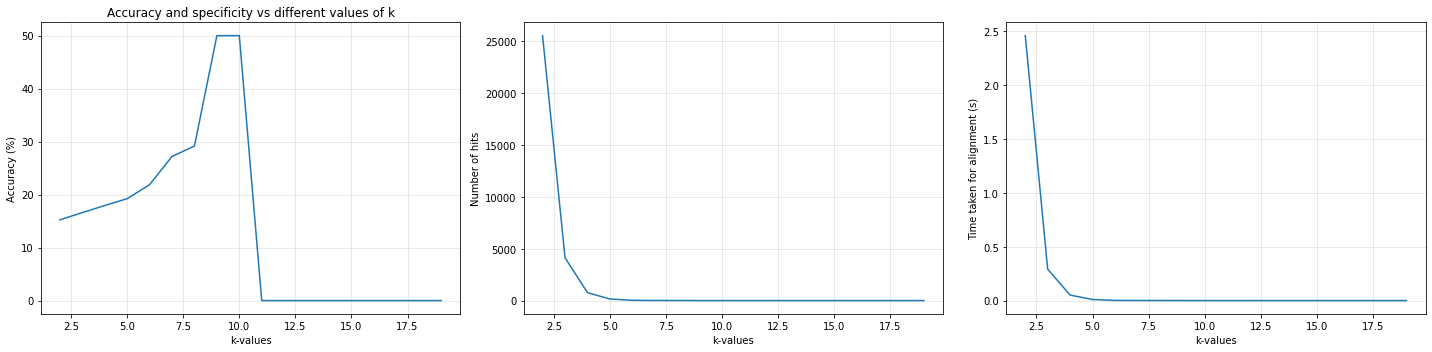

In [13]:
query = "ACATGATATCGATACGAATCAGAATAGC"
subSeq = str(genome)
meanAcc = []
timeTaken = []
k_values = range(2, 20)
specificity =[]
max_Value = [0, 0, 0]
'''
iterates through the matching, followed by alignment algorithms for each value of k
'''
for i in k_values:
  hits = matchAlgo(query, subSeq, i)
  if len(hits.shape) == 1:
    np.reshape(hits, (1, 3), axis = 0)
  # print(hits)
  specificity = np.append(specificity, len(hits))
  if hits.any():
    duration, accuracy, maximum = alignAlg(hits, query, subSeq)
  else:
    duration, accuracy, max = 0, 0, [0, 0, 0]
  # print(accuracy)
  meanAcc = np.append(meanAcc, np.mean(accuracy))
  if not maximum[2] == 0 and max_Value[2] < maximum[2]:
    max_Value = maximum
  timeTaken = np.append(timeTaken, duration)
#print(meanAcc)
print(f'The query sequence is likely to start at position {str(int(max_Value[0]+1))} and end at {str(int(max_Value[1]+1))} with an accuracy of {str(max_Value[2]*100)}')

#Code to display the graphs
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 5))
ax[0].plot(k_values, meanAcc*100)
ax[1].plot(k_values, specificity)
ax[2].plot(k_values, timeTaken)
ax[0].set_ylabel('Accuracy (%)')
ax[1].set_ylabel('Number of hits')
ax[2].set_ylabel('Time taken for alignment (s)')
ax[0].set_title('Accuracy and specificity vs k-values')
ax[1].set_title('Number of hits vs k-values')
ax[2].set_title('Time taken for alignment vs k-values')
ax[0].set_xlabel('k-values')
ax[1].set_xlabel('k-values')
ax[2].set_xlabel('k-values')

for a in ax:
    a.grid(alpha=.35)
fig.tight_layout()
plt.show()

> Did your computer take a long time to run the above command? Just ask your computer to run FASTA 🤣

Now, we would like to try applying our model to actual genomic data. We will be using Cytochrome C DNA data from a variety of felids. 

We chose Cytochrome C as it is known to be a highly conserved gene [4]. 

> Cytochrome C Fun Facts: The known structures of c-type cytochromes have six different classes of fold. Of these, four are unique to c-type cytochromes. This arrangement is shared by all proteins known to belong to the Cytochrome C family, which presently includes both mono-haem proteins and multi-haem proteins. This entry represents mono-haem Cytochrome C proteins (excluding class II and f-type cytochromes), such as Cytochromes C, C1, C2, C5, C555, C550 to C553, C556, and C6.

Using the same query sequence for all DNA sequences, we will attempt to see if our code provides results that is in line with the sequences being highly conserved. We will be querying these sequences with a randomly selected segment of amino acid sequence from *Acinonyx Jubatus*. We also added in our randomly generated genome sequence, which should yield low accuracy of matching with the query sequence.

As for our selection of felids, well... cats! 😸

The 9 cat species' Cytochrome C Oxidase I (MT-CO1) DNA sequences were sourced from NCBI's Nucleotide Database. We used the Genbank Coding Sequences FASTA Nucleotide record for each DNA sequence.

Lynx rufus: https://www-ncbi-nlm-nih-gov.libproxy1.nus.edu.sg/nuccore/NC_014456.1?from=6241&to=7785&report=genbank

Acinonyx jubatus: https://www-ncbi-nlm-nih-gov.libproxy1.nus.edu.sg/nuccore/NC_005212.1?from=6240&to=7784&report=genbank

Felis catus: https://www-ncbi-nlm-nih-gov.libproxy1.nus.edu.sg/nuccore/NC_001700.1?from=6216&to=7760&report=genbank

Felis nigripes: https://www-ncbi-nlm-nih-gov.libproxy1.nus.edu.sg/nuccore/NC_028309.1?from=6113&to=7657&report=genbank

Leopardus guigna: https://www-ncbi-nlm-nih-gov.libproxy1.nus.edu.sg/nuccore/NC_028321.1?from=6161&to=7705&report=genbank

Leopardus pardalis: https://www-ncbi-nlm-nih-gov.libproxy1.nus.edu.sg/nuccore/NC_028315.1?from=6014&to=7558&report=genbank

Prionailurus planiceps: https://www-ncbi-nlm-nih-gov.libproxy1.nus.edu.sg/nuccore/NC_028312.1?from=6076&to=7620&report=genbank

Prionailurus rubiginosus: https://www-ncbi-nlm-nih-gov.libproxy1.nus.edu.sg/nuccore/NC_028304.1?from=6200&to=7744&report=genbank

Puma concolor: https://www-ncbi-nlm-nih-gov.libproxy1.nus.edu.sg/nuccore/NC_016470.1?from=6263&to=7807&report=genbank

In [11]:
from urllib.request import urlopen

#Load Cytochrome C DNA sequence

def readURL(url):
  file=urlopen(url)
  file.readline() #discards first line of information regarding the genome
  output=file.read().decode("utf-8", "ignore")
  output=output.replace("\n","")
  return seqToAa(output)

Species={
    "Acinonyx_Jubatus":readURL("https://raw.githubusercontent.com/BriLHR/SP2273/main/Acinonyx_Jubatus_DNAseq.txt"),
    "Felis_Catus":readURL("https://raw.githubusercontent.com/BriLHR/SP2273/main/Felis_Catus_DNAseq.txt"),
    "Felis_Nigripes":readURL("https://raw.githubusercontent.com/BriLHR/SP2273/main/Felis_Nigripes_DNAseq.txt"),
    "Leopardus_Guigna":readURL("https://raw.githubusercontent.com/BriLHR/SP2273/main/Leopardus_Guigna_DNAseq.txt"),
    "Leopardus_Pardalis":readURL("https://raw.githubusercontent.com/BriLHR/SP2273/main/Leopardus_Pardalis_DNAseq.txt"),
    "Lynx_Rufus":readURL("https://raw.githubusercontent.com/BriLHR/SP2273/main/Lynx_Rufus_DNAseq.txt"),
    "Prionailarus_Planiceps":readURL("https://raw.githubusercontent.com/BriLHR/SP2273/main/Prionailurus_Planiceps_DNAseq.txt"),
    "Prionailarus_Rubiginosus":readURL("https://raw.githubusercontent.com/BriLHR/SP2273/main/Prionailurus_Rubiginosus_DNAseq.txt"),
    "Puma_Concolor":readURL("https://raw.githubusercontent.com/BriLHR/SP2273/main/Puma_Concolor_DNAseq.txt"),
    "Randomly generated sequence": genome
}

Current sequence being searched: Acinonyx_Jubatus. The query sequence is likely to start at position 7 and end at 60 with an accuracy of 100.0


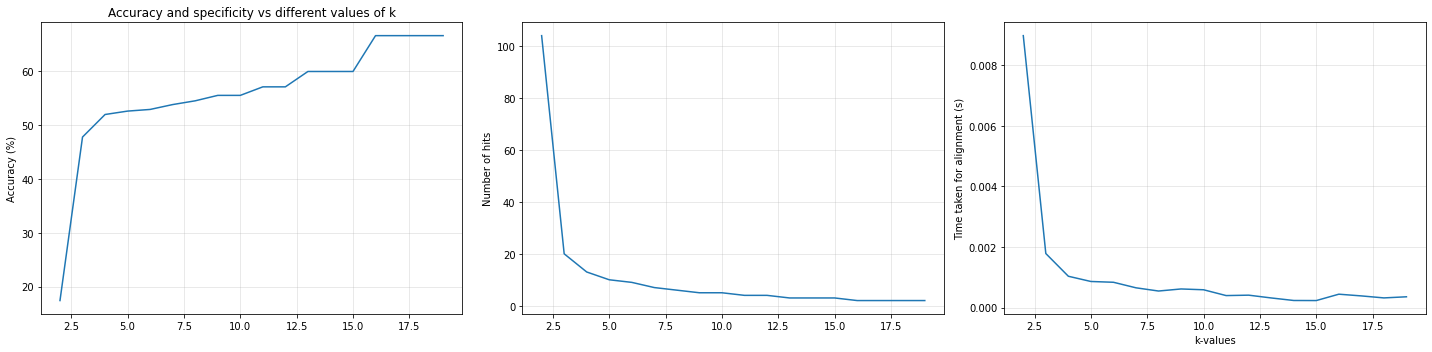

Current sequence being searched: Felis_Catus. The query sequence is likely to start at position 7 and end at 60 with an accuracy of 98.14814814814815


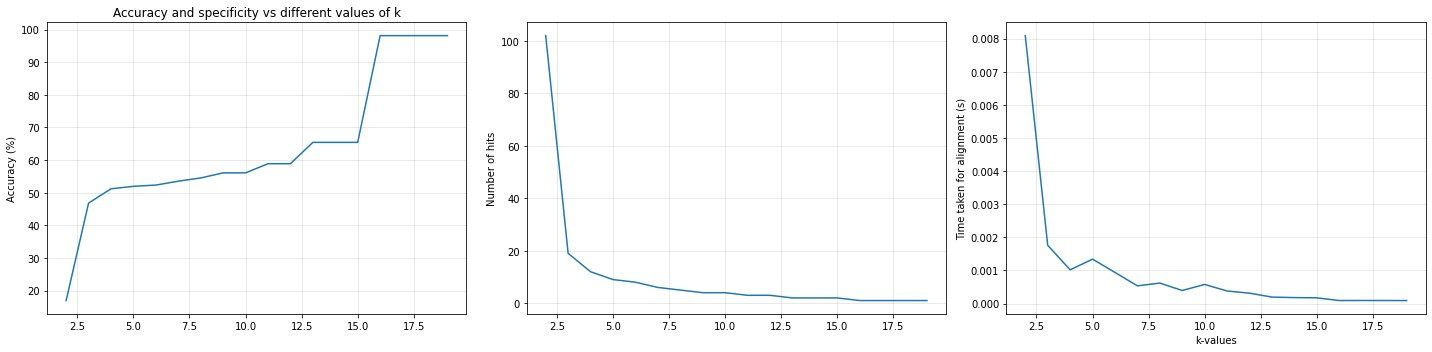

Current sequence being searched: Felis_Nigripes. The query sequence is likely to start at position 7 and end at 60 with an accuracy of 98.14814814814815


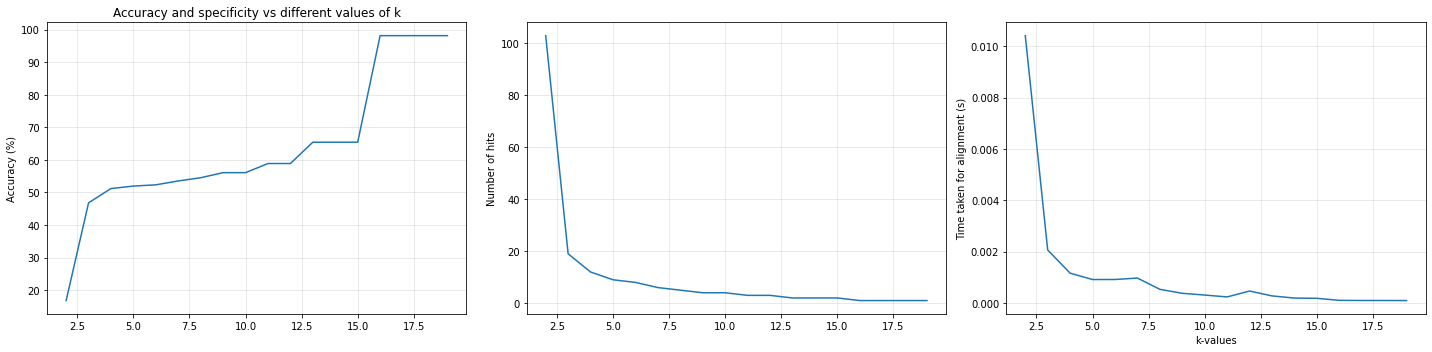

Current sequence being searched: Leopardus_Guigna. The query sequence is likely to start at position 7 and end at 60 with an accuracy of 98.14814814814815


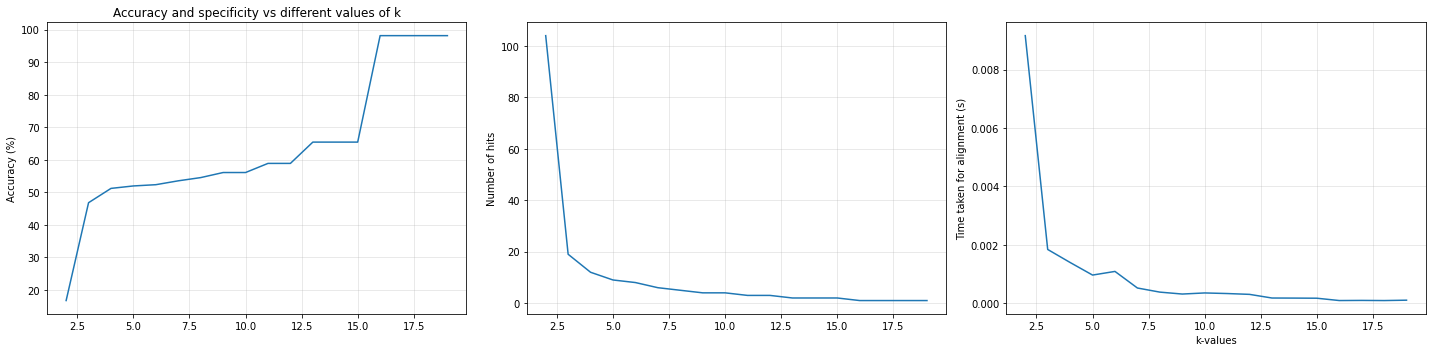

Current sequence being searched: Leopardus_Pardalis. The query sequence is likely to start at position 7 and end at 60 with an accuracy of 98.14814814814815


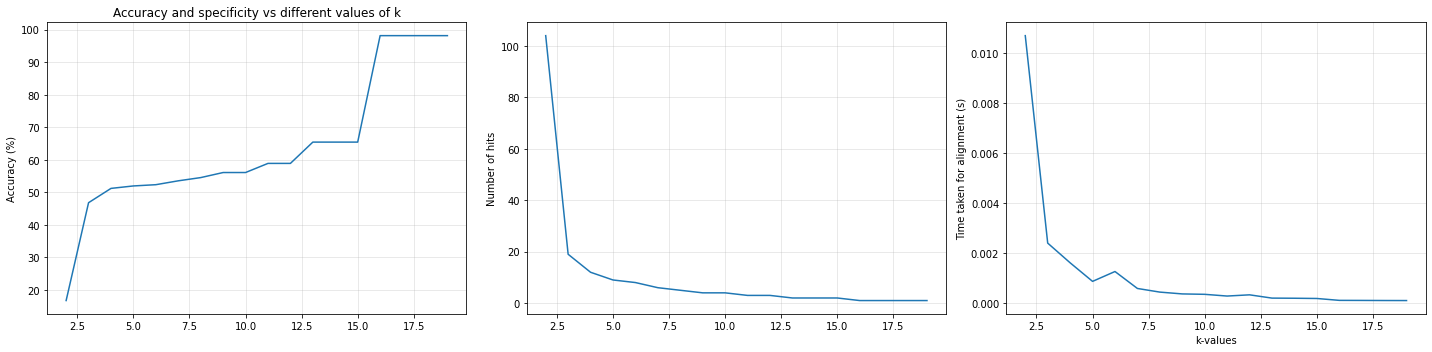

Current sequence being searched: Lynx_Rufus. The query sequence is likely to start at position 7 and end at 60 with an accuracy of 96.29629629629629


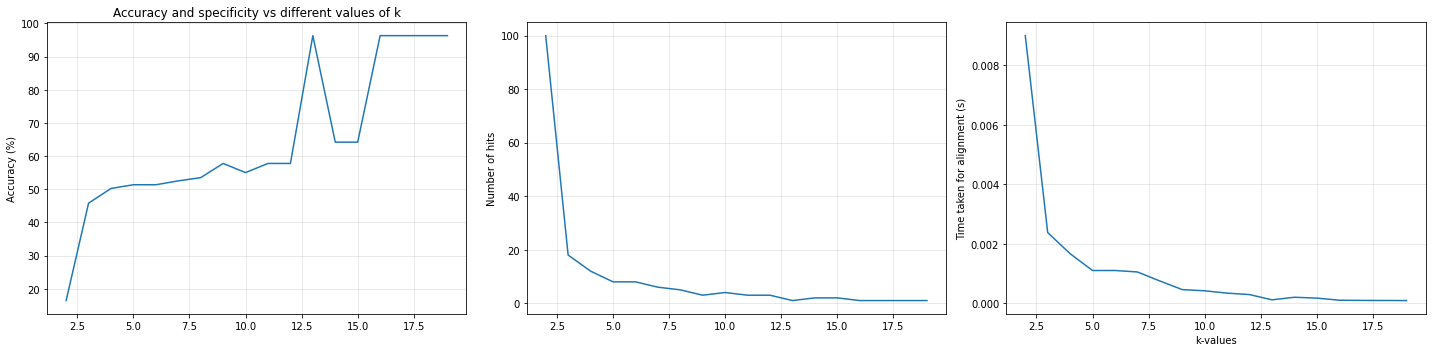

Current sequence being searched: Prionailarus_Planiceps. The query sequence is likely to start at position 7 and end at 60 with an accuracy of 98.14814814814815


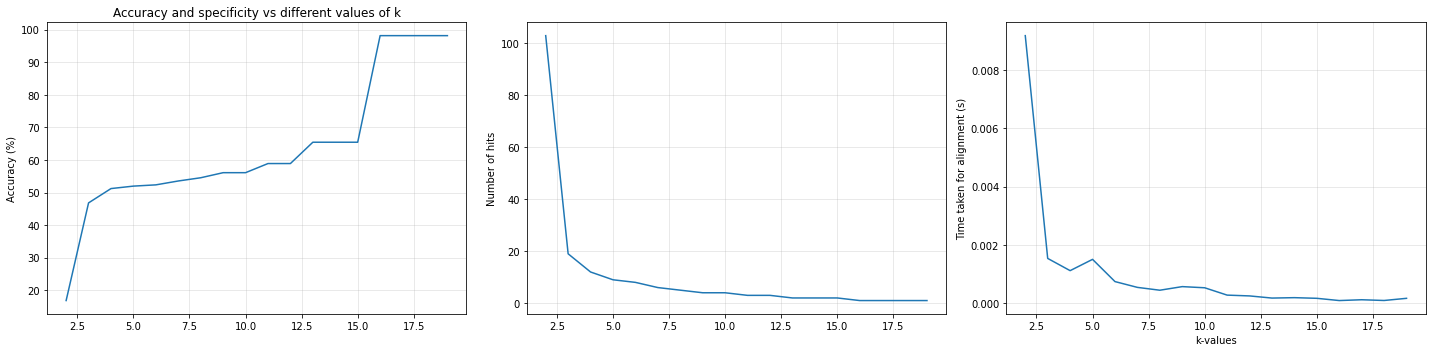

Current sequence being searched: Prionailarus_Rubiginosus. The query sequence is likely to start at position 7 and end at 60 with an accuracy of 100.0


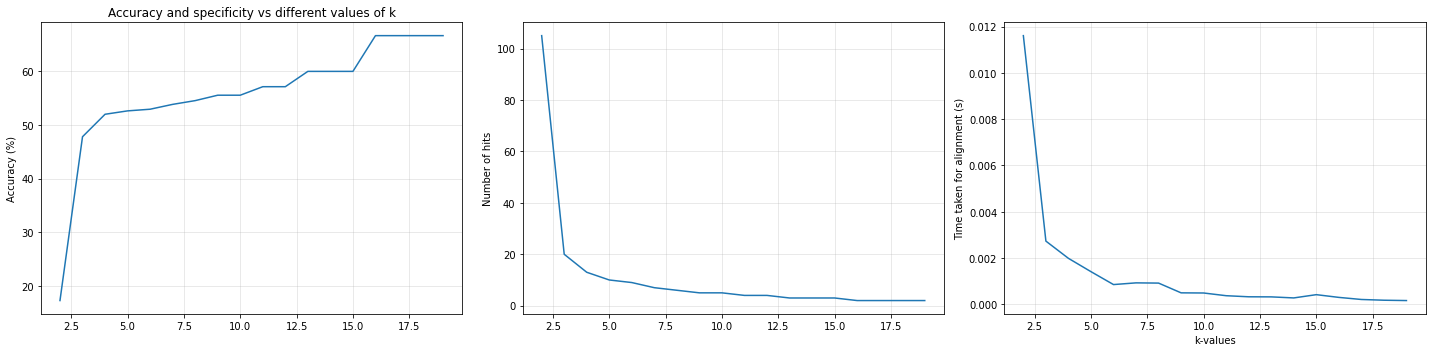

Current sequence being searched: Puma_Concolor. The query sequence is likely to start at position 7 and end at 60 with an accuracy of 96.29629629629629


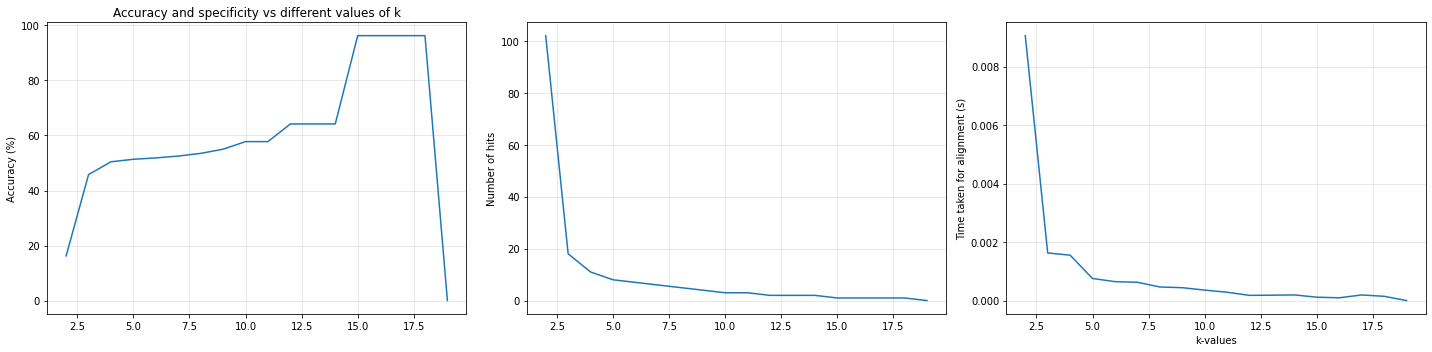

Current sequence being searched: Randomly generated sequence. The query sequence is likely to start at position 2981 and end at 3034 with an accuracy of 20.37037037037037


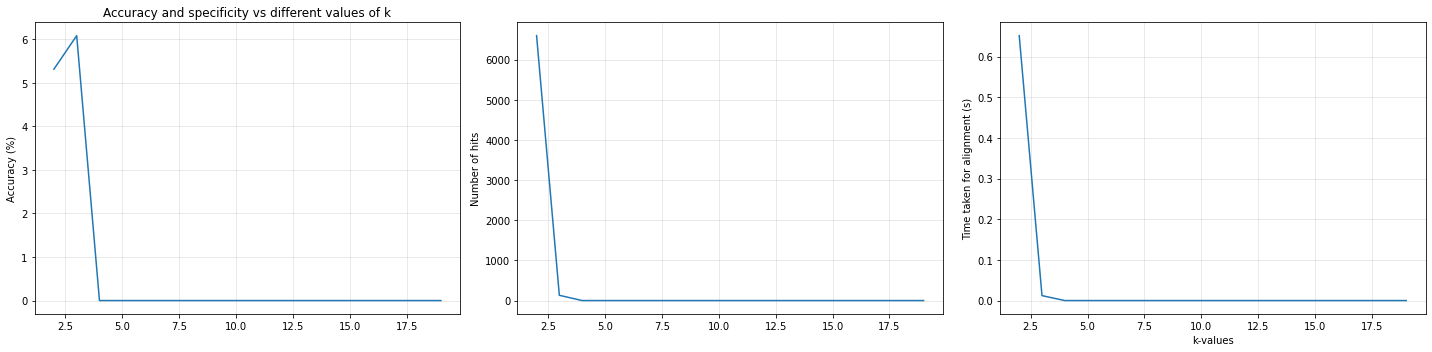

In [12]:
#Testing our code with actual genetic data
query = "LFSTNHKDIGTLYLLFGA*AGIVGTALSLLIRAELGQPGTLLGDDQIYNVIVTA"

for key in Species:
  subSeq=str(Species[key])
  #print(subSeq)
  meanAcc = []
  timeTaken = []
  k_values = range(2, 20)
  specificity = []
  max_Value = [0, 0, 0]
  #iterates through the matching, followed by alignment algorithms for each value of k
  for i in k_values:
    hits = matchAlgo(query, subSeq, i)
    if len(hits.shape) == 1:
      np.reshape(hits, (1, 3), axis = 0)
    # print(hits)
    specificity = np.append(specificity, len(hits))
    if hits.any():
      duration, accuracy, maximum = alignAlg(hits, query, subSeq)
    else:
      duration, accuracy, max = 0, 0, [0, 0, 0]
    # print(accuracy)
    meanAcc = np.append(meanAcc, np.mean(accuracy))
    if not maximum[2] == 0 and max_Value[2] < maximum[2]:
      max_Value = maximum
    timeTaken = np.append(timeTaken, duration)
  #print(meanAcc)
  print(f'Current sequence being searched: {key}. The query sequence is likely to start at position {str(int(max_Value[0]+1))} and end at {str(int(max_Value[1]+1))} with an accuracy of {str(max_Value[2]*100)}')
  #Code to display the graphs
  fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 5))
  ax[0].plot(k_values, meanAcc*100)
  ax[1].plot(k_values, specificity)
  ax[2].plot(k_values, timeTaken)
  ax[0].set_ylabel('Accuracy (%)')
  ax[1].set_ylabel('Number of hits')
  ax[2].set_ylabel('Time taken for alignment (s)')
  ax[0].set_title('Accuracy and specificity vs k-values')
  ax[1].set_title('Number of hits vs k-values')
  ax[2].set_title('Time taken for alignment vs k-values')


  ax[0].set_xlabel('k-values')
  ax[1].set_xlabel('k-values')
  ax[2].set_xlabel('k-values')

  for a in ax:
      a.grid(alpha=.35)
  fig.tight_layout()
  plt.show()

The felid sequences all yield an accuracy of above 95%, which is a decent number for us to say that the sequences are indeed similar. This is in line with the fact that there are multiple studies showcasing Cytochrome C being a highly conserved sequence. 

The first graph depicts the change of accuracy as k-value increases. It can be observed that accuracy generally increases with a larger k-value, as there will be more data for the algorithm to use and match with the sequence. However, the trade off is increased computational runtime as k-value increases.

The second graph shows the number of hits sharply decreasing as k-value increases. This occurs as a larger k-value means the criteria to count as a "hit" will be stricter, given the larger sequence to match.

The last graph follows a similar trend to graph two, and occurs as the algorithm will need to process less "hits".

For the last randomly generated genomic sequence, it only yields an accuracy of about 20%. This shows that the sequence is not similar (which we obviously won't expect it to be). The 1st graph depicts a rapid drop in accuracy as k-value increases. This is such as trying to match a longer sequence would simply not yield any matches, resulting in 0% accuracy.

This brings forward to possibility of using our code to locate consensus sequences. We can recursively string splice a genome to obtain the query that can yield the highest accuracy throughout multiple species.

## Discussion
From the graphs above, we can see that the k-value that we choose has big implications on how long the code takes to run, as well as the overall accuracy of the hits generated. 

For instance, the number of hits returned by the matching algorithm significantly decreases as k increases, and consequently the time taken by the alignment algorithm also decreases. Although these numbers are insignificant at this scale, it becomes much more important when real genomes are being used, which easily contain upwards of 3 billion base pairs in the case of a human. Furthermore, the algorithms used here are relatively simple compared to the actual BLAT and BLAST algorithms, meaning that the matching and alignment sequences used by BLAT and BLAST would naturally take more time, as they would have much greater time complexity. 

Similarly, increasing the k-value beyond a certain point results in there being no matches at all. Even though there is a possibility that the sequence does contain a homologous region, the matching algorithm simply does not recognize the k-mer and hence skips over it. This is analagous to BLAT and BLAST, where a k-value that is too large will result in the algorithm becoming too selective, and skips over potential homologous regions. 

What does this all mean? In short, it means that the value of k is very important when it comes to DNA or protein alignment. A value too small means that the algorithm is not specific enough, and iterates through too many hits. A value too large means that the algorithm is too selective and strict, and searches using criteria that the query and genomic sequences cannot satisfy. 



## Conclusion
Our algorithms attempt to simplify BLAT and BLAST into something much easier to understand, while keeping the essence of both algorithms in terms of its use of k-mers to find homology between subsequences, and then extending out to align the DNA further. We used our algorithms to look into the k-value that is used in the algorithm, and have shown the importance of using an appropriate value of k depending on sequence type and length. Finally, we used our algorithm to find regions of homology in Cytochrome C sequences of various animals to show proof of concept on real-life examples. 

Overall, sequence alignment has a very diverse set of uses in genetics, from finding conserved sequences in genomes to locating particular genetic sequence within a string of DNA. Furthermore, with additional modifications, sequence alignment algorithms can potentially have a much wider use outside of genetics, such as in social sciences, as explored by Shoval et al. [5]. Future work could include improvements to our existing algorithms to make it more robust, such as accounting for insertions, deletions, and alternative splicing that could occur during the process of transcription. 

## References
1. Embl-Ebi. (n.d.). Emboss needle. EBI. Retrieved April 1, 2022, from https://www.ebi.ac.uk/Tools/psa/emboss_needle/ 
2. U.S. National Library of Medicine. (n.d.). Blast: Basic local alignment search tool. National Center for Biotechnology Information. Retrieved March 6, 2022, from https://blast.ncbi.nlm.nih.gov/Blast.cgi
3. Kent, W. J. (2002). Blat—the blast-like alignment tool. Genome Research, 12(4), 656–664. https://doi.org/10.1101/gr.229202 
4. Pettigrew, G. W., &amp; Moore, G. R. (1987). Cytochromes C: Biological aspects. Springer-Verlag. 
5. Shoval, N., & Isaacson, M. (2007). Sequence alignment as a method for human activity analysis in space and time. Annals of the Association of American geographers, 97(2), 282-297.